In [0]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
cmap = matplotlib.cm.get_cmap('Spectral')

import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier,AdaBoostRegressor

# Ejemplo de Boosting y Feature Selection

Vamos a tratar de ver alguna aplicacion de lo visto la clase pasada. Para eso, implementaremos un algoritmo de Boosting. En particular, voy a aprovechar para bucear un poco en otras cosas.

# El problema:

En esta cuarentena, yo estoy con abstinencia de deportes. En particular, me cortaron la temporada de NBA. Con mi grupo de adictos, empezamos a charlar para matar el tiempo y me surgio una pregunta. ~Puedo hablar de basquet en vez de trabajar?~ Puedo mentir con seguridad sobre las estadisticas que leo en los articulos?

Para eso, me puse a explorar un poco. En primer lugar, necesito datos. Para eso, recurro a una pagina llamada basketballreference.com donde se almacenan todos los datos posibles. Para hacer las cosas mas simples, me voy a limitar a una unica temporada, en la que los roles posicionales son mas o menos los mismos en la liga (salvo en Houston) y no tengo jugadores repetidos (salvo los que fueron transferidos, pero ahora mismo no me interesa ser demasiado cauto en el procesado).

In [0]:
from urllib.request import urlopen
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np

In [0]:
BeautifulSoup?

In [0]:
url = "https://www.basketball-reference.com/leagues/NBA_{}_advanced.html".format(2016)# this is the HTML from the given URL
html = urlopen(url)
soup = BeautifulSoup(html)

In [0]:
soup.findAll('tr', limit=2)# use getText()to extract the text we need into a list
headers = [th.getText() for th in soup.findAll('tr', limit=2)[0].findAll('th')]# exclude the first column as we will not need the ranking order from Basketball Reference for the analysis

In [0]:
headers = headers[1:]
rows = soup.findAll('tr')[1:]
player_stats = [[td.getText() for td in rows[i].findAll('td')] for i in range(len(rows))]
stats = pd.DataFrame(player_stats, columns = headers)
stats=stats.drop('\xa0',axis=1)

In [8]:
stats.head()

,Player,Pos,Age,Tm,G,MP,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP
0,Quincy Acy,PF,25,SAC,59,876,14.7,.629,.229,.318,8.1,15.1,11.6,4.4,1.6,2.2,10.0,13.1,1.8,0.7,2.5,.137,-0.2,0.2,-0.1,0.4
1,Jordan Adams,SG,21,MEM,2,15,17.3,.427,.167,.833,0.0,15.9,7.6,31.9,10.3,0.0,19.6,30.5,0.0,0.0,0.0,.015,-2.5,9.4,6.9,0.0
2,Steven Adams,C,22,OKC,80,2014,15.5,.621,.000,.460,12.5,16.1,14.4,4.3,1.0,3.3,14.1,12.6,4.2,2.3,6.5,.155,0.0,0.2,0.2,1.1
3,Arron Afflalo,SG,30,NYK,71,2371,10.9,.531,.298,.164,1.1,11.0,6.1,9.9,0.5,0.3,8.7,17.9,1.8,0.9,2.7,.055,-1.3,-1.6,-2.9,-0.5
4,Alexis Ajinça,C,27,NOP,59,861,13.8,.514,.003,.197,9.3,25.9,17.3,5.8,1.1,3.4,13.6,20.4,0.2,0.9,1.0,.058,-3.4,-0.6,-4.0,-0.4


En particular, todo a partir de OWS son estadisticas que me hablan de "cuan bueno es un jugador", por lo que quiero ver si puedo estimar alguna en funcion de todas las previas. En particular, me voy a concentrar en WS. El objetivo que me voy a plantear es saber cuales son las estadisticas mas importantes para saber cuan bueno es un jugador.

In [0]:
stats['Pos'].value_counts()

PG       129
PF       122
SG       116
SF       105
C        104
SG-SF      1
PF-C       1
Name: Pos, dtype: int64

# El procesado

En principio, yo tengo mi dataframe y ahora lo unico que voy a hacer es separar en Train y Test y luego elegir mi target variable ('WS/48'). En particular, voy considerar jugadores que jugaron cierta cantidad de los partidos, para asegurarme de tener algo de estadistica, siempre tratando de tener una muestra suficientemente grande.

In [0]:
stats_now=stats.copy()
stats_now=stats_now[stats_now['Pos'].isin(['SG','PF','PG','C','SF'])]
stats_now["G"]=pd.to_numeric(stats_now["G"])
stats_now=stats_now[stats_now["G"]>=40]
stats_now["WS"]=pd.to_numeric(stats_now["WS"])

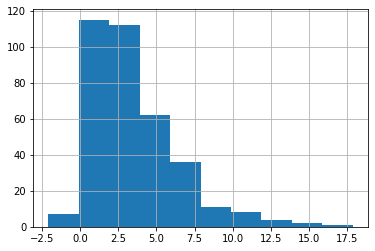

In [85]:
stats_now["WS"].hist()

Viendo WS tengo un par de opciones. En particular, aca voy a implementar asignar clases dependiendo del cuartil de WS al que pertenece el jugador o a un sistema de binnes. 

In [86]:
#stats_now["WS/48_q"]=pd.qcut(stats_now['WS/48'], 4)
#stats_now["X_q"]=pd.qcut(stats_now['WS'].values, 4).codes
stats_now["X_q"]=pd.cut(stats_now['WS'].values, bins=[-2.5,0.0,3.0,8.0,19]).codes
print(stats_now["X_q"].value_counts())

1    180
2    139
3     25
0     14
Name: X_q, dtype: int64


In [87]:
print(stats_now.iloc[np.where(stats_now["Player"]=="LeBron James")])

           Player Pos Age   Tm   G    MP  ... WS/48 OBPM DBPM  BPM VORP X_q
275  LeBron James  SF  31  CLE  76  2709  ...  .242  7.0  2.0  9.0  7.5   3

[1 rows x 27 columns]


Courtney Lee        2
Jared Cunningham    2
P.J. Hairston       2
Ty Lawson           2
Marcus Thornton     2
                   ..
Jimmy Butler        1
Cameron Payne       1
Anthony Davis       1
Festus Ezeli        1
Pau Gasol           1
Name: Player, Length: 343, dtype: int64


(array([328.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  15.]),
 array([1. , 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. ]),
 <a list of 10 Patch objects>)

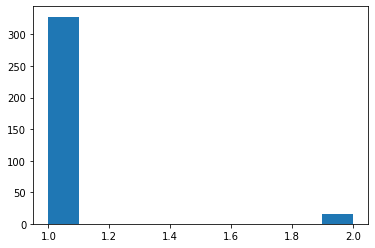

In [88]:
print(stats_now['Player'].value_counts())
plt.hist(stats_now['Player'].value_counts())

In [92]:
stats_now=stats_now.replace(['PG','SG','SF','PF','C'],[1,2,3,4,5])
stats_now['Pos'].value_counts()

2    77
4    75
1    73
3    71
5    62
Name: Pos, dtype: int64

In [93]:
np.where(stats_now.applymap(lambda x: x == ''))

(array([], dtype=int64), array([], dtype=int64))

En particular, voy a estratificar (esto no se hace falta si hice cuartiles pero si de utilizar bines fijos)



In [0]:
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=445543)
for train_index, test_index in split.split(stats_now, stats_now["X_q"]):
    strat_train_set = stats_now.iloc[train_index]
    strat_test_set = stats_now.iloc[test_index]

Veamos si puedo implementar un regresor.

In [0]:
stats_train = strat_train_set.drop(["Player","Tm","X_q","OWS","DWS","WS","WS/48","OBPM","DBPM","BPM","VORP"], axis=1) # drop labels for training set
stats_train_labels = strat_train_set["X_q"].copy()
stats_test = strat_test_set.drop(["Player","Tm","X_q","OWS","DWS","WS","WS/48","OBPM","DBPM","BPM","VORP"], axis=1) # drop labels for training set
stats_test_labels = strat_test_set["X_q"].copy()


In [96]:
from sklearn.model_selection import GridSearchCV

clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier())

param_grid = {#"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best"],
              "n_estimators": [500],
              "base_estimator__max_depth": [3],
              "base_estimator__max_features": [5],
              "base_estimator__min_samples_leaf": [5]
             }

# run grid search
grid_search = GridSearchCV(clf, cv=10, param_grid=param_grid)
grid_search.fit(stats_train, stats_train_labels)

GridSearchCV(cv=10, error_score=nan,
             estimator=AdaBoostClassifier(algorithm='SAMME.R',
                                          base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                                                class_weight=None,
                                                                                criterion='gini',
                                                                                max_depth=None,
                                                                                max_features=None,
                                                                                max_leaf_nodes=None,
                                                                                min_impurity_decrease=0.0,
                                                                                min_impurity_split=None,
                                                                                min_samples_leaf=1,


In [97]:
print(grid_search.best_estimator_)
print(grid_search.best_score_)
print(grid_search.cv_results_['mean_test_score'])
print(grid_search.cv_results_['std_test_score'])

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=3,
                                                         max_features=5,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=5,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                             

Hola overfitting!

In [98]:
mejor_estimador=grid_search.best_estimator_
mejor_estimador.fit(stats_train, stats_train_labels)
print("Results is: ", mejor_estimador.score(stats_train, stats_train_labels))

Results is:  1.0


In [99]:
features=np.asarray(list(stats_train.columns.values))
for i in range(len(features)):
  print((features[i],mejor_estimador.feature_importances_[i]))

('Pos', 0.010681168052786084)
('Age', 0.06360944807091905)
('G', 0.04652151588107184)
('MP', 0.10641510717043819)
('PER', 0.10766057295348527)
('TS%', 0.14156938026996202)
('3PAr', 0.0400357045472484)
('FTr', 0.06712385234424299)
('ORB%', 0.0432334133888809)
('DRB%', 0.052838033438643066)
('TRB%', 0.03612790915235326)
('AST%', 0.06874029903757804)
('STL%', 0.043093646607744306)
('BLK%', 0.043473884017024816)
('TOV%', 0.05922897349130475)
('USG%', 0.0696470915763171)


In [100]:
mejor_estimador.predict(stats_train.iloc[np.where(strat_train_set["Player"]=="James Harden")])

array([3], dtype=int8)

Podemos sacar mas informacion viendo la matriz de confusion

In [101]:
from sklearn.metrics import confusion_matrix
confusion_matrix(stats_train_labels,mejor_estimador.predict(stats_train))

array([[ 11,   0,   0,   0],
       [  0, 144,   0,   0],
       [  0,   0, 111,   0],
       [  0,   0,   0,  20]])

En efecto, algo que esta muy bien es que solo puedo mal interpretar de un cuartil a sus vecinos. Es decir, no voy a asignar a un jugador con muy bajo WS al cuartil con mas alto WS.

En particular, vamos a ver en que jugadores le pifio:

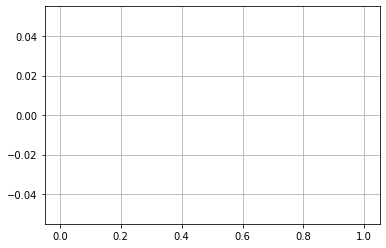

In [102]:
strat_train_set.iloc[np.where(mejor_estimador.predict(stats_train)!=stats_train_labels)]["X_q"].hist()

En particular, que jugadores "de elite" estoy pifiando?

In [103]:
strat_train_set.iloc[np.where(mejor_estimador.predict(stats_train)!=stats_train_labels)][["Player","X_q"]]

,Player,X_q


Veamos el test

In [104]:
print(mejor_estimador.score(stats_test, stats_test_labels))
print(confusion_matrix(stats_test_labels,mejor_estimador.predict(stats_test)))

0.8194444444444444
[[ 0  3  0  0]
 [ 0 30  6  0]
 [ 0  2 26  0]
 [ 0  0  2  3]]


Muchisimo overfitting pro igual compro. Me habian quedado demasiados pocos de elite en el test pero se ve que le puedo pifiar.